[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  Volume  \
Ticker             ^NSEI         ^NSEI         ^NSEI         ^NSEI   ^NSEI   
Date                                                                         
2023-12-22  21349.400391  21390.500000  21232.449219  21295.849609  284700   
2023-12-26  21441.349609  21477.150391  21329.449219  21365.199219  219500   
2023-12-27  21654.750000  21675.750000  21495.800781  21497.650391  256500   
2023-12-28  21778.699219  21801.449219  21678.000000  21715.000000  393100   
2023-12-29  21731.400391  21770.300781  21676.900391  21737.650391  270900   

Price              BB_MA      BB_Upper      BB_Lower          VWAP  \
Ticker                                                               
Date                                                                 
2023-12-22  20831.387500  21877.731494  19785.043506  17986.720566   
2023-12-26  20913.720020  21872.033026  19955.407013  17992.395311   
2023-12-27  21001.972559 

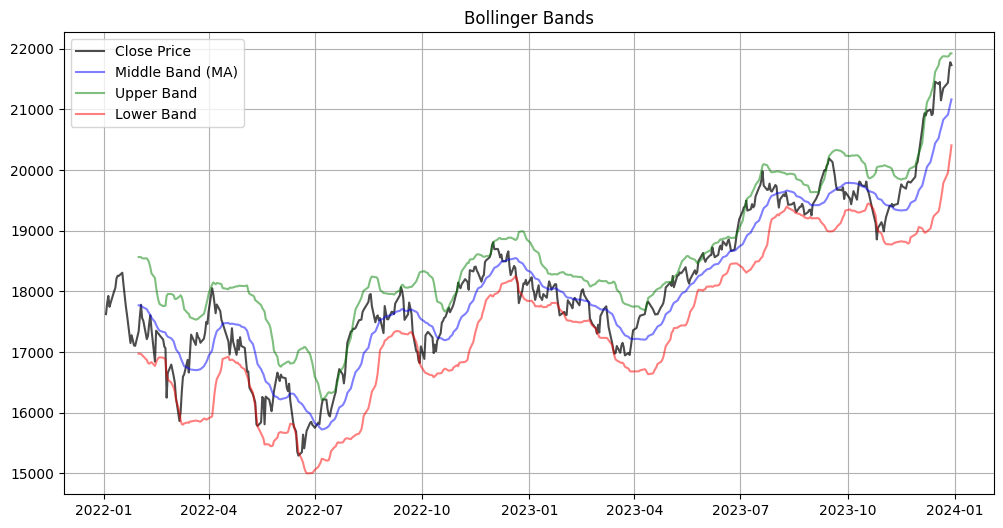

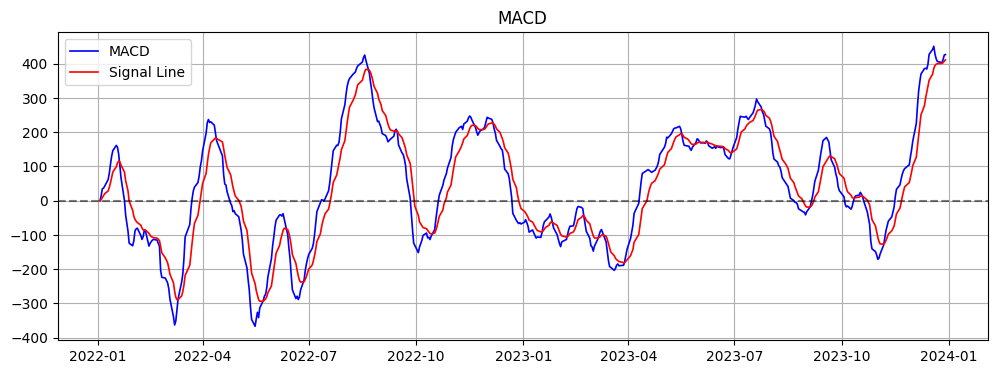

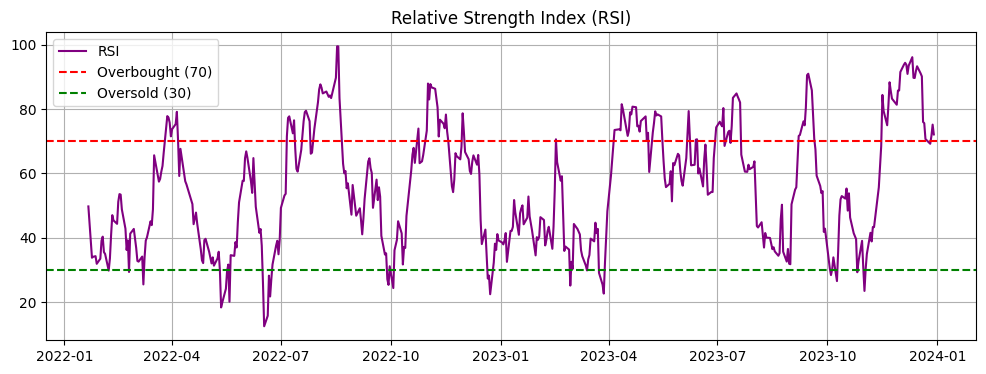

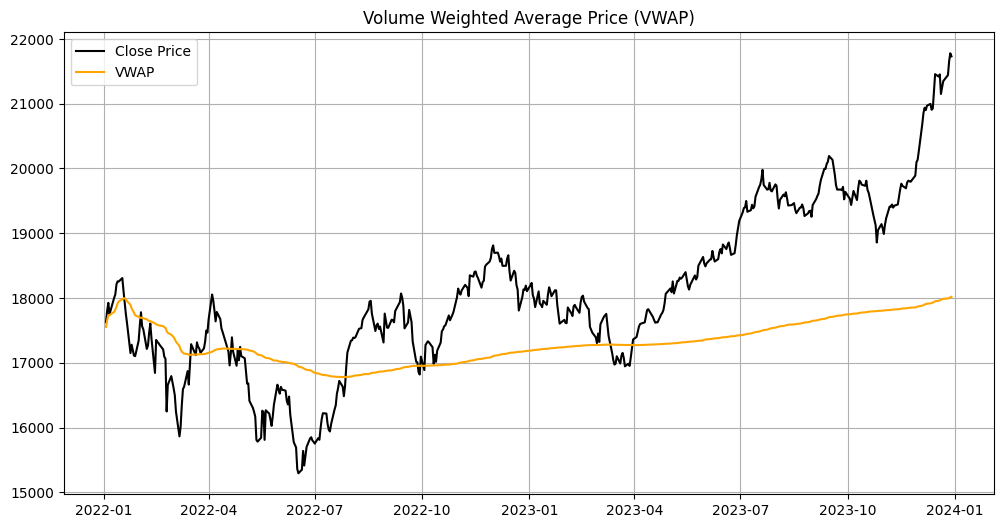

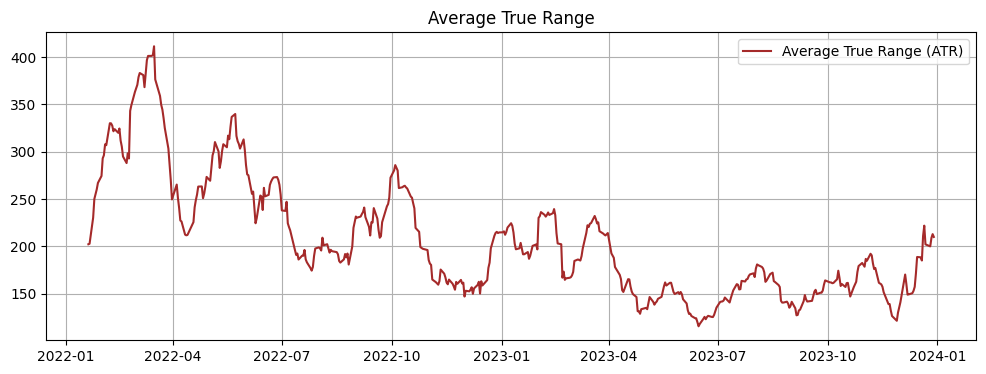

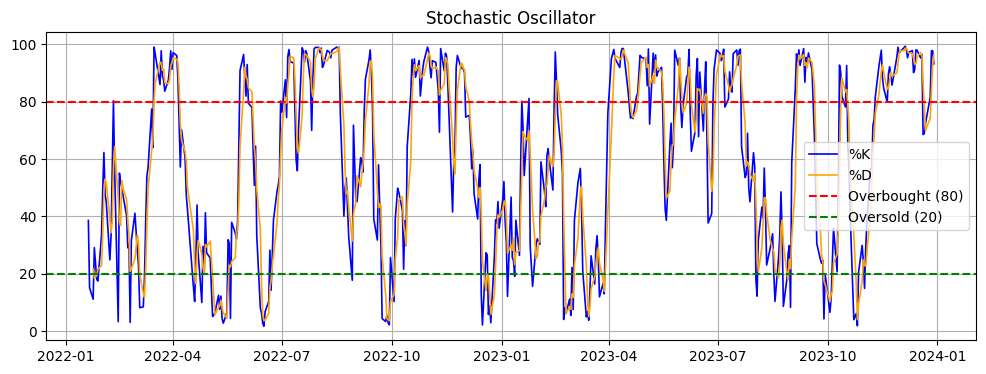

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def download_data(ticker='^NSEI', start='2022-01-01', end='2024-01-01'):
    df = yf.download(ticker, start=start, end=end, interval='1d')
    df.dropna(inplace=True)
    return df
def add_bollinger_bands(df, window=20, num_std=2):
    """Bollinger bands strategy is where middle blue line in 20day SMA and the green line and the red line are SMA ( + or -) 2*std respectively
    if the stock crosses the green line, its a sell call and if the stock crosses below the red line, its a buy call, this strategy works best in 
    sideways market trend """
    ma = df['Close'].rolling(window=window).mean()
    std = df['Close'].rolling(window=window).std()
    df['BB_MA'] = ma
    df['BB_Upper'] = ma + num_std * std
    df['BB_Lower'] = ma - num_std * std
    return df
def add_vwap(df):
    """VWAP, or Volume Weighted Average Price, is a technical analysis indicator that shows the average price of a security over a specific time
    period, weighted by the volume traded at each price"""
    df = df.copy()  # Avoid modifying original DataFrame
    tp = (df['High'] + df['Low'] + df['Close']) / 3  # Fixed: Removed parentheses around 3
    df['VWAP'] = (tp * df['Volume']).cumsum() / df['Volume'].cumsum()
    return df
def add_macd(df, short_window=12, long_window=26, signal_window=9):
    """ the macd strategy has two lines, one the 12D EMA - 26D EMA(blue) and the 9day EMA(red), if the MACD line goes below the red line, its a 
    selling signal and if it crosses above, its a buy signal"""
    df['EMA12'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD_Signal'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    return df
def add_rsi(df, period=14):
    """ the rsi strategy has a formula ( written in the code) and if the value crosses 70, its a sell signal as the strength is too high and the 
    stock is bound to fall, when the value is below 30, its a buy signal"""
    delta = df['Close'].diff()
    gain = delta.clip(lower=0).rolling(window=period).mean()
    loss = -delta.clip(upper=0).rolling(window=period).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df
def add_atr(df, period=14):
    """quantifies market volatilty by calculating average price fluctuation"""
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = tr.rolling(window=period).mean()
    return df
def add_stochastic_oscillator(df, k_period=14, d_period=3):
    low_min = df['Low'].rolling(window=k_period).min()
    high_max = df['High'].rolling(window=k_period).max()
    df['%K'] = 100 * ((df['Close'] - low_min) / (high_max - low_min))
    df['%D'] = df['%K'].rolling(window=d_period).mean()
    return df
def add_all_indicators(df):
    df = add_bollinger_bands(df)
    df = add_vwap(df)
    df = add_macd(df)
    df = add_rsi(df)
    df = add_atr(df)
    df = add_stochastic_oscillator(df)
    return df
def plot_bollinger_bands(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Close'], label='Close Price', color='black', alpha=0.7)
    plt.plot(df['BB_MA'], label='Middle Band (MA)', color='blue', alpha=0.5)
    plt.plot(df['BB_Upper'], label='Upper Band', color='green', alpha=0.5)
    plt.plot(df['BB_Lower'], label='Lower Band', color='red', alpha=0.5)
    plt.title('Bollinger Bands')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_macd(df):
    plt.figure(figsize=(12, 4))
    plt.plot(df['MACD'], label='MACD', color='blue', linewidth=1.2)
    plt.plot(df['MACD_Signal'], label='Signal Line', color='red', linewidth=1.2)
    plt.axhline(0, linestyle='--', color='black', alpha=0.5)
    plt.title('MACD')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_rsi(df):
    plt.figure(figsize=(12, 4))
    plt.plot(df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', color='red', label='Overbought (70)')
    plt.axhline(30, linestyle='--', color='green', label='Oversold (30)')
    plt.title('Relative Strength Index (RSI)')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_vwap(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Close'], label='Close Price', color='black')
    plt.plot(df['VWAP'], label='VWAP', color='orange')
    plt.title('Volume Weighted Average Price (VWAP)')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_atr(df):
    plt.figure(figsize=(12, 4))
    plt.plot(df['ATR'], label='Average True Range (ATR)', color='brown')
    plt.title('Average True Range')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_stochastic_oscillator(df):
    plt.figure(figsize=(12, 4))
    plt.plot(df['%K'], label='%K', color='blue', linewidth=1.2)
    plt.plot(df['%D'], label='%D', color='orange', linewidth=1.2)
    plt.axhline(80, linestyle='--', color='red', label='Overbought (80)')
    plt.axhline(20, linestyle='--', color='green', label='Oversold (20)')
    plt.title('Stochastic Oscillator')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_all(df):
    plot_bollinger_bands(df)
    plot_macd(df)
    plot_rsi(df)
    plot_vwap(df)
    plot_atr(df)
    plot_stochastic_oscillator(df)
df = download_data()
df = add_all_indicators(df)
print(df.tail())  # Confirm output
plot_all(df)



In [9]:
# QUESTION 2
def generate_bollinger_signals(df):
    df['BB_Signal'] = 0
    df.loc[df['Close'] < df['BB_Lower'], 'BB_Signal'] = 1  # Buy
    df.loc[df['Close'] > df['BB_Upper'], 'BB_Signal'] = -1  # Sell
    return df
def generate_vwap_signals(df):
    df['VWAP_Signal'] = 0
    df.loc[df['Close'] > df['VWAP'], 'VWAP_Signal'] = 1
    df.loc[df['Close'] < df['VWAP'], 'VWAP_Signal'] = -1
    return df
def generate_macd_signals(df):
    df['MACD_Signal_Gen'] = 0
    mask = df['MACD'] > df['MACD_Signal']
    df.loc[mask & (df['MACD'].shift(1) <= df['MACD_Signal'].shift(1)), 'MACD_Signal_Gen'] = 1
    df.loc[~mask & (df['MACD'].shift(1) >= df['MACD_Signal'].shift(1)), 'MACD_Signal_Gen'] = -1
    return df
def generate_rsi_signals(df):
    df['RSI_Signal'] = 0
    df.loc[df['RSI'] < 30, 'RSI_Signal'] = 1
    df.loc[df['RSI'] > 70, 'RSI_Signal'] = -1
    return df
def generate_atr_signals(df):
    df['ATR_Signal'] = 0
    atr_thresh = df['ATR'].mean()
    df['Return'] = df['Close'].pct_change()
    df.loc[df['Return'] > 2 * atr_thresh / df['Close'], 'ATR_Signal'] = 1
    df.loc[df['Return'] < -2 * atr_thresh / df['Close'], 'ATR_Signal'] = -1
    df.drop(columns='Return', inplace=True)
    return df
def generate_stochastic_signals(df):
    df['Stoch_Signal'] = 0
    df.loc[(df['%K'] < 20) & (df['%D'] < 20), 'Stoch_Signal'] = 1
    df.loc[(df['%K'] > 80) & (df['%D'] > 80), 'Stoch_Signal'] = -1
    return df
def generate_all_signals(df):
    # df = generate_bollinger_signals(df)
    # df = generate_vwap_signals(df)
    df = generate_macd_signals(df)
    df = generate_rsi_signals(df)
    # df = generate_atr_signals(df)
    df = generate_stochastic_signals(df)
    return df
def count_signals(df):
    signals = {
        'Bollinger': df['BB_Signal'].value_counts().to_dict(),
        'VWAP': df['VWAP_Signal'].value_counts().to_dict(),
        'MACD': df['MACD_Signal_Gen'].value_counts().to_dict(),
        'RSI': df['RSI_Signal'].value_counts().to_dict(),
        'ATR': df['ATR_Signal'].value_counts().to_dict(),
        'Stochastic': df['Stoch_Signal'].value_counts().to_dict(),
    }
    for name, counts in signals.items():
        buy = counts.get(1, 0)
        sell = counts.get(-1, 0)
        print(f"{name}: Buy Signals = {buy}, Sell Signals = {sell}")
df = generate_all_signals(df)
count_signals(df)

"""Bollinger bands and Vwap are giving major compilation errors"""

Bollinger: Buy Signals = 0, Sell Signals = 0
VWAP: Buy Signals = 0, Sell Signals = 0
MACD: Buy Signals = 17, Sell Signals = 16
RSI: Buy Signals = 30, Sell Signals = 132
ATR: Buy Signals = 0, Sell Signals = 0
Stochastic: Buy Signals = 43, Sell Signals = 151
